In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
air = pd.read_excel('/content/Airlines+Data.xlsx')
air

Month  Passengers
0  1995-01-01         112
1  1995-02-01         118
2  1995-03-01         132
3  1995-04-01         129
4  1995-05-01         121
..        ...         ...
91 2002-08-01         405
92 2002-09-01         355
93 2002-10-01         306
94 2002-11-01         271
95 2002-12-01         306

[96 rows x 2 columns]

In [3]:
air.isna().sum()


Month         0
Passengers    0
dtype: int64

In [ ]:
air.duplicated().sum()

In [6]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [7]:
air.describe()

Passengers
count   96.000000
mean   213.708333
std     71.918216
min    104.000000
25%    156.000000
50%    200.000000
75%    264.750000
max    413.000000

In [8]:
air['month'] = air.Month.dt.strftime('%b')
air['year'] = air.Month.dt.strftime('%Y')

air['t'] = np.arange(1,len(air)+1)
air['t_squared'] = np.square(air.t)

air['log_passengers'] = np.log(air.Passengers) 


air.head()

Month  Passengers month  year  t  t_squared  log_passengers
0 1995-01-01         112   Jan  1995  1          1        4.718499
1 1995-02-01         118   Feb  1995  2          4        4.770685
2 1995-03-01         132   Mar  1995  3          9        4.882802
3 1995-04-01         129   Apr  1995  4         16        4.859812
4 1995-05-01         121   May  1995  5         25        4.795791

In [9]:
air1 = air[['t' , 't_squared', 'month' , 'Passengers', 'log_passengers']]
air1.head()

t  t_squared month  Passengers  log_passengers
0  1          1   Jan         112        4.718499
1  2          4   Feb         118        4.770685
2  3          9   Mar         132        4.882802
3  4         16   Apr         129        4.859812
4  5         25   May         121        4.795791

In [10]:
air1 = pd.get_dummies(air1)
air1.head() 

t  t_squared  Passengers  log_passengers  month_Apr  month_Aug  month_Dec  \
0  1          1         112        4.718499          0          0          0   
1  2          4         118        4.770685          0          0          0   
2  3          9         132        4.882802          0          0          0   
3  4         16         129        4.859812          1          0          0   
4  5         25         121        4.795791          0          0          0   

   month_Feb  month_Jan  month_Jul  month_Jun  month_Mar  month_May  \
0          0          1          0          0          0          0   
1          1          0          0          0          0          0   
2          0          0          0          0          1          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          1   

   month_Nov  month_Oct  month_Sep  
0          0          0          0  
1          0          0          0  
2          0          0          0  
3          0          0          0  
4          0          0          0

<Axes: >

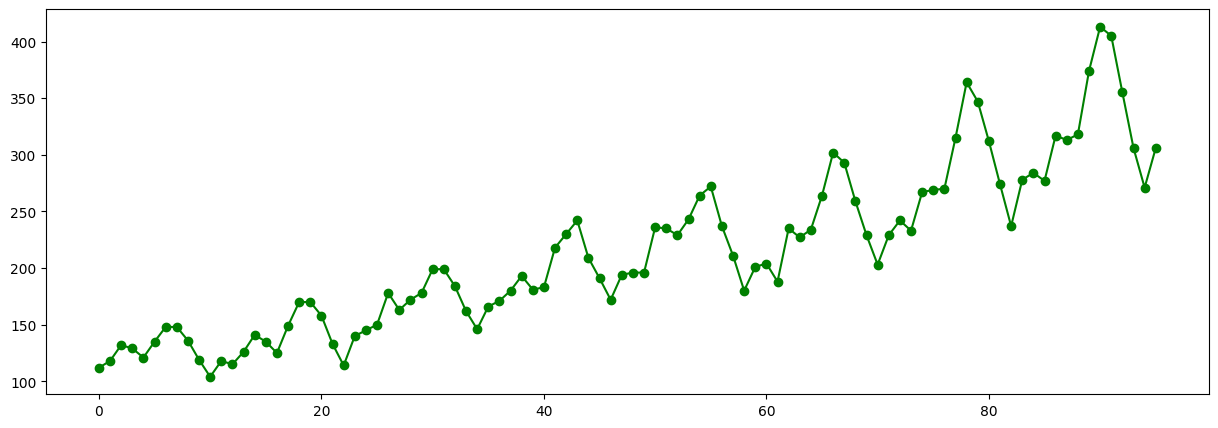

In [14]:
air['Passengers'].plot(figsize=(15, 5),color='green',marker='o')  

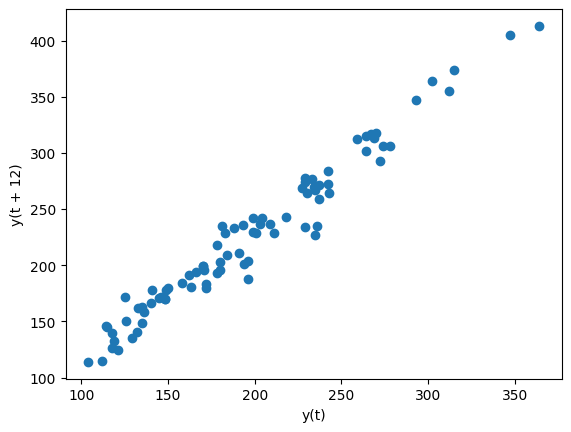

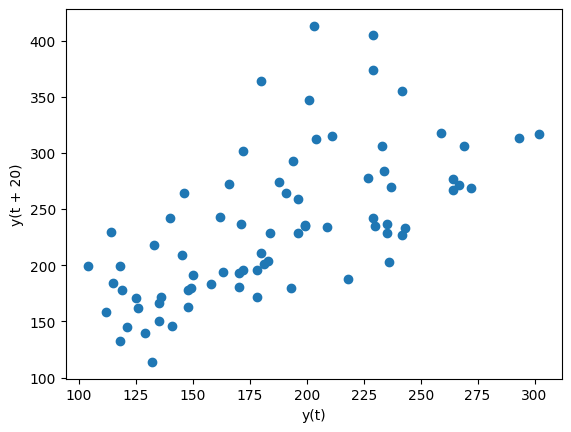

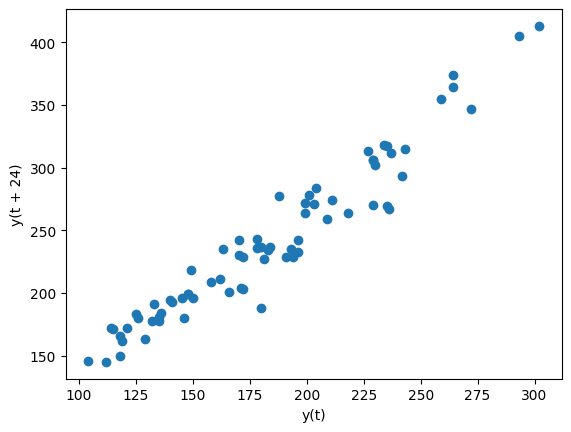

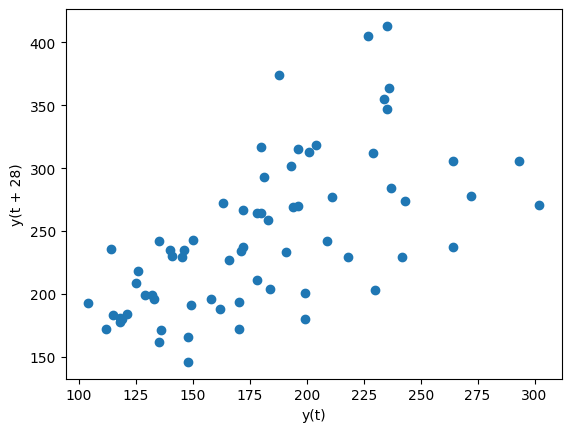

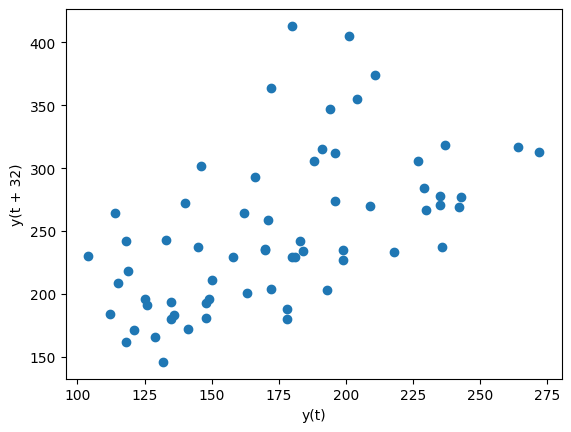

In [16]:
from pandas.plotting import lag_plot

for i in [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]:
    lag_plot(air.Passengers, lag=i)
    plt.show()

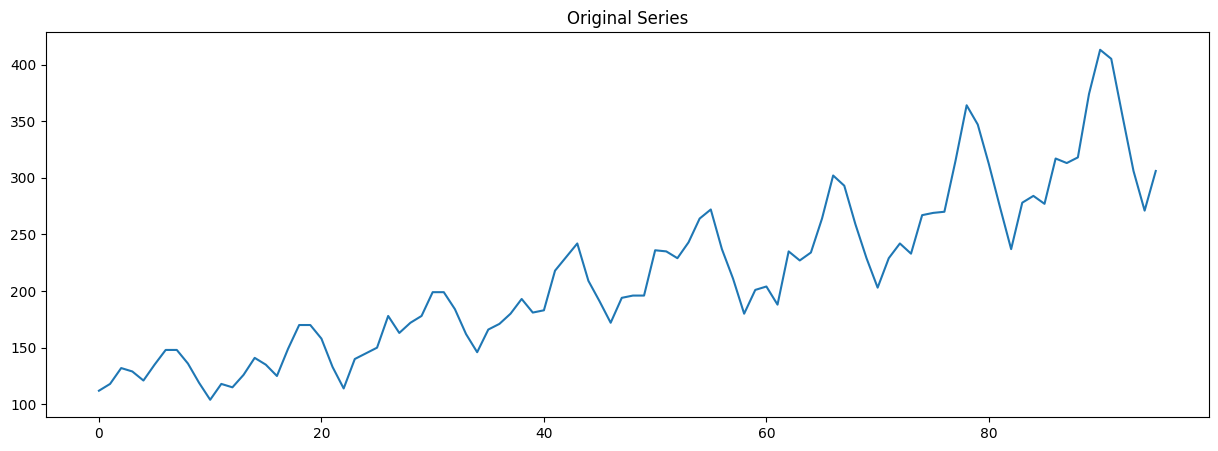

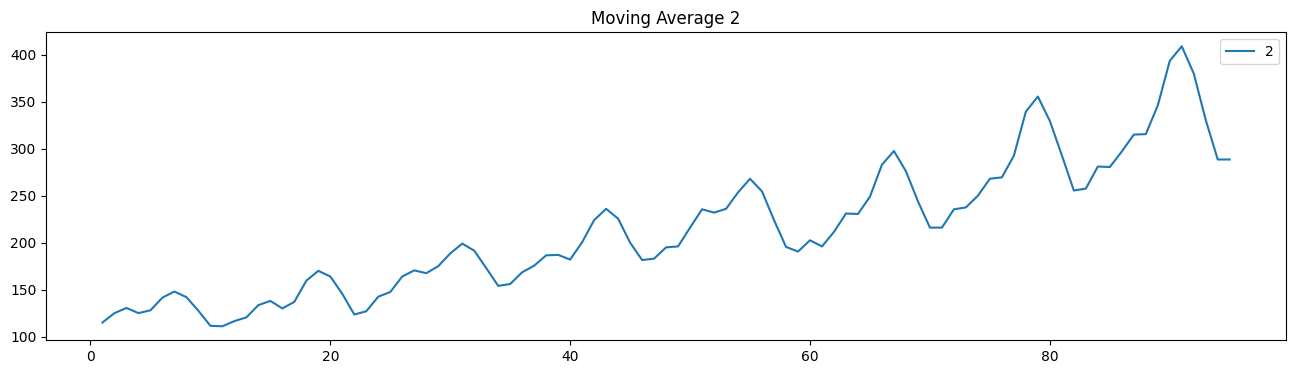

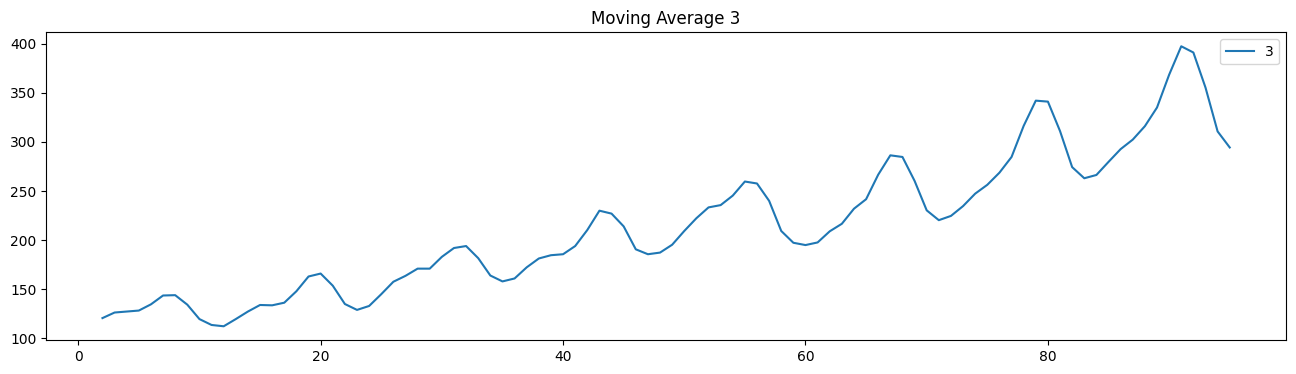

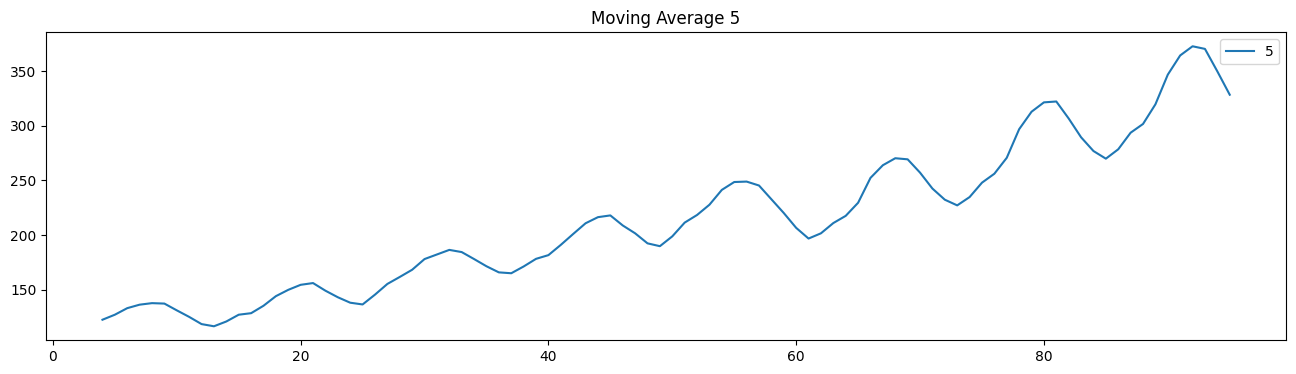

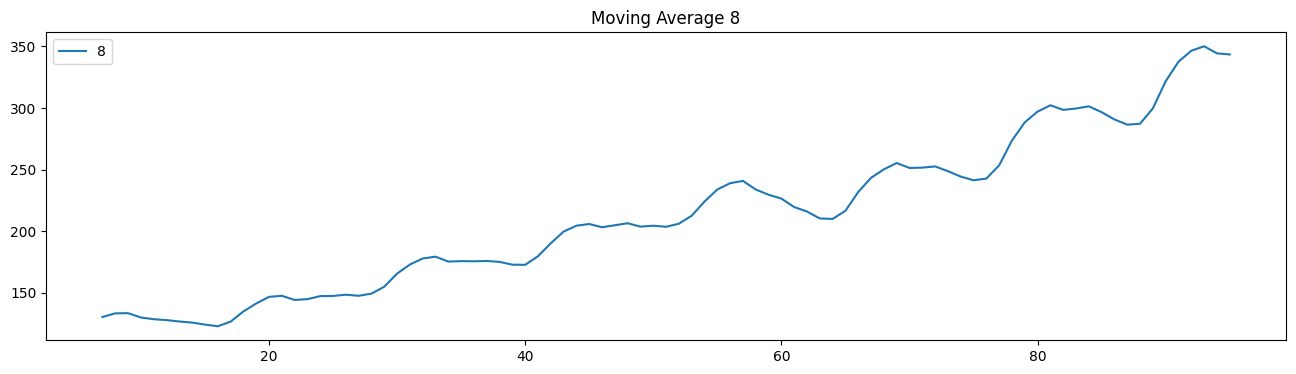

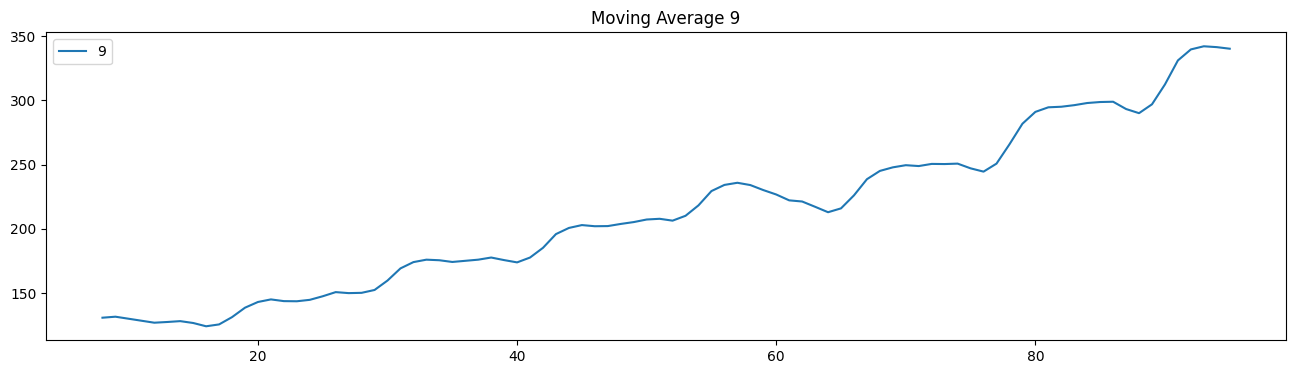

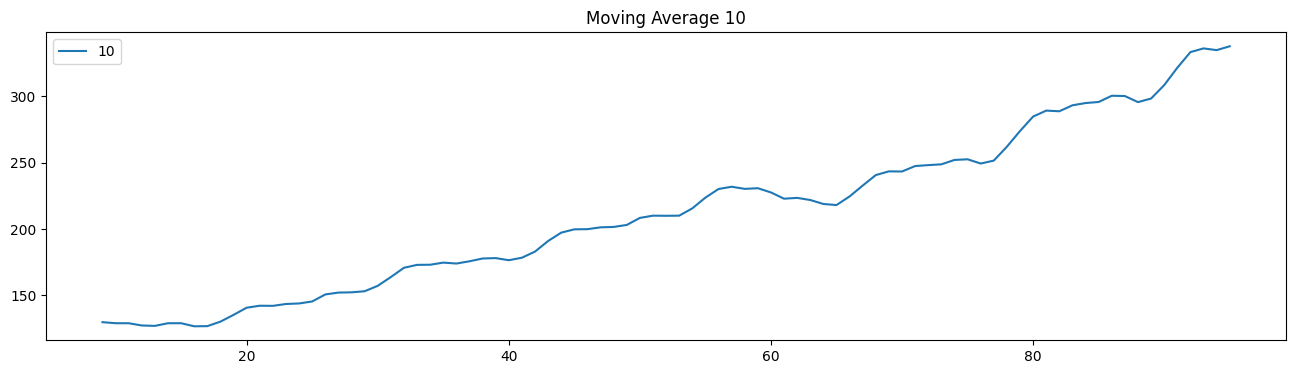

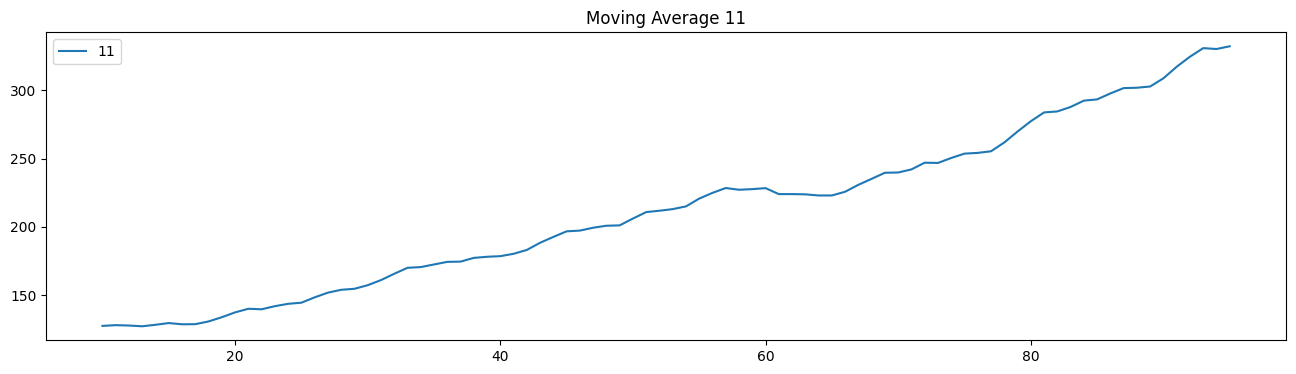

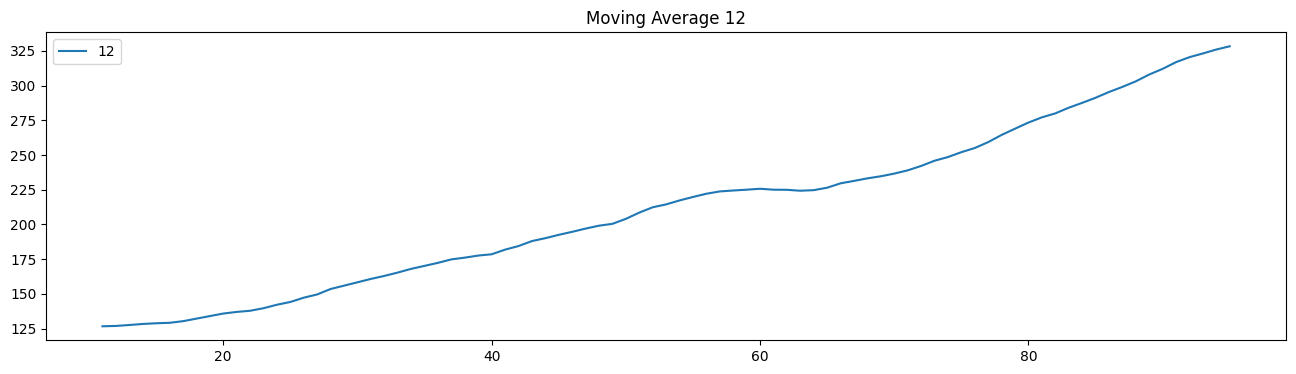

In [17]:
plt.figure(figsize=(15,5))
air.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    air["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show() 

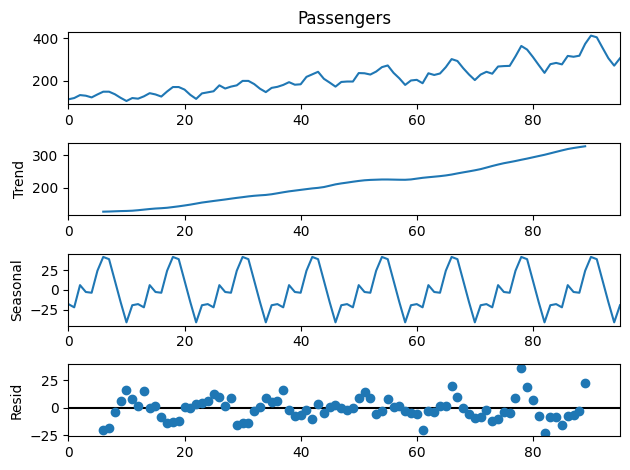

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose 

decompose_ts_add = seasonal_decompose(air.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

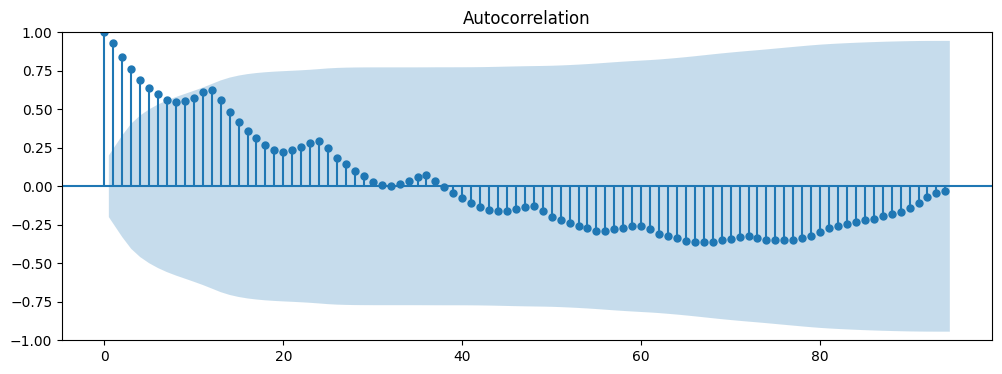

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots
plt.rc("figure", figsize=(12,4)) 
tsa_plots.plot_acf(air.Passengers,lags=94)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


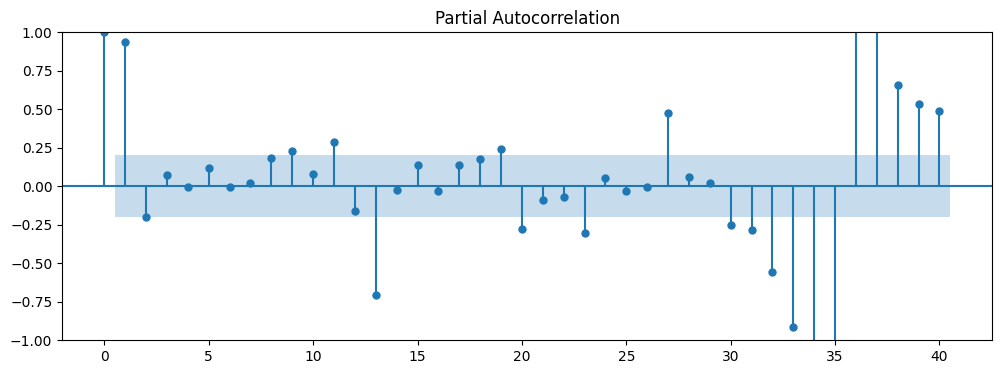

In [20]:
plt.rc("figure", figsize=(12,4))
tsa_plots.plot_pacf(air.Passengers,lags=40)
plt.show()

In [21]:
Train = air1.head(72)
Test = air1.tail(24)

In [23]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.667792995646266

In [24]:
Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

42.55232894600461

In [25]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

51.99073640155397

In [26]:
add_sea = smf.ols('Passengers ~ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',  data=Train).fit()

pred_add_sea = pd.Series(add_sea.predict(Test[[ 'month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea 

127.2645156532034

In [27]:
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.241608485930655

In [28]:
Mul_sea = smf.ols('log_passengers ~ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea 

132.18762800263448

In [29]:
Mul_Add_sea = smf.ols('log_passengers ~ t+ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

132.18762800263448

In [30]:
data = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values']) 

MODEL  RMSE_Values
4  add_sea_quad    35.241608
1           Exp    42.552329
0        linear    51.667793
2          Quad    51.990736
3       add_sea   127.264516
5      Mult_sea   132.187628
6  Mult_add_sea   132.187628

In [32]:
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=air1).fit()
pred= add_sea_Quad.predict(air1.tail()) #predicting on historic data 
forecast_df = pd.DataFrame()

forecast_df['actual_passengers'] = air1.Passengers.tail()
forecast_df['Predicted_passengers'] = np.round(pred, 0)

forecast_df

actual_passengers  Predicted_passengers
91                405                 371.0
92                355                 344.0
93                306                 317.0
94                271                 293.0
95                306                 319.0

In [33]:
new_df = pd.DataFrame() 
new_df['t'] = np.arange(97,109,1) 
new_df['t_squared'] = np.square(new_df.t)
new_df['month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
new_df = pd.get_dummies(new_df)
new_df.head()

t  t_squared  month_Apr  month_Aug  month_Dec  month_Feb  month_Jan  \
0   97       9409          0          0          0          0          1   
1   98       9604          0          0          0          1          0   
2   99       9801          0          0          0          0          0   
3  100      10000          1          0          0          0          0   
4  101      10201          0          0          0          0          0   

   month_Jul  month_Jun  month_Mar  month_May  month_Nov  month_Oct  month_Sep  
0          0          0          0          0          0          0          0  
1          0          0          0          0          0          0          0  
2          0          0          1          0          0          0          0  
3          0          0          0          0          0          0          0  
4          0          0          0          1          0          0          0

In [34]:
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=air1).fit()
pred= add_sea_Quad.predict(new_df) 

new_df['forcasted'] = pred

new_df 

t  t_squared  month_Apr  month_Aug  month_Dec  month_Feb  month_Jan  \
0    97       9409          0          0          0          0          1   
1    98       9604          0          0          0          1          0   
2    99       9801          0          0          0          0          0   
3   100      10000          1          0          0          0          0   
4   101      10201          0          0          0          0          0   
5   102      10404          0          0          0          0          0   
6   103      10609          0          0          0          0          0   
7   104      10816          0          1          0          0          0   
8   105      11025          0          0          0          0          0   
9   106      11236          0          0          0          0          0   
10  107      11449          0          0          0          0          0   
11  108      11664          0          0          1          0          0   

    month_Jul  month_Jun  month_Mar  month_May  month_Nov  month_Oct  \
0           0          0          0          0          0          0   
1           0          0          0          0          0          0   
2           0          0          1          0          0          0   
3           0          0          0          0          0          0   
4           0          0          0          1          0          0   
5           0          1          0          0          0          0   
6           1          0          0          0          0          0   
7           0          0          0          0          0          0   
8           0          0          0          0          0          0   
9           0          0          0          0          0          1   
10          0          0          0          0          1          0   
11          0          0          0          0          0          0   

    month_Sep   forcasted  
0           0  328.328687  
1           0  329.438178  
2           0  359.547668  
3           0  354.907159  
4           0  356.141650  
5           0  385.376141  
6           0  413.360631  
7           0  412.845122  
8           1  385.829613  
9           0  358.939103  
10          0  335.423594  
11          0  362.283085

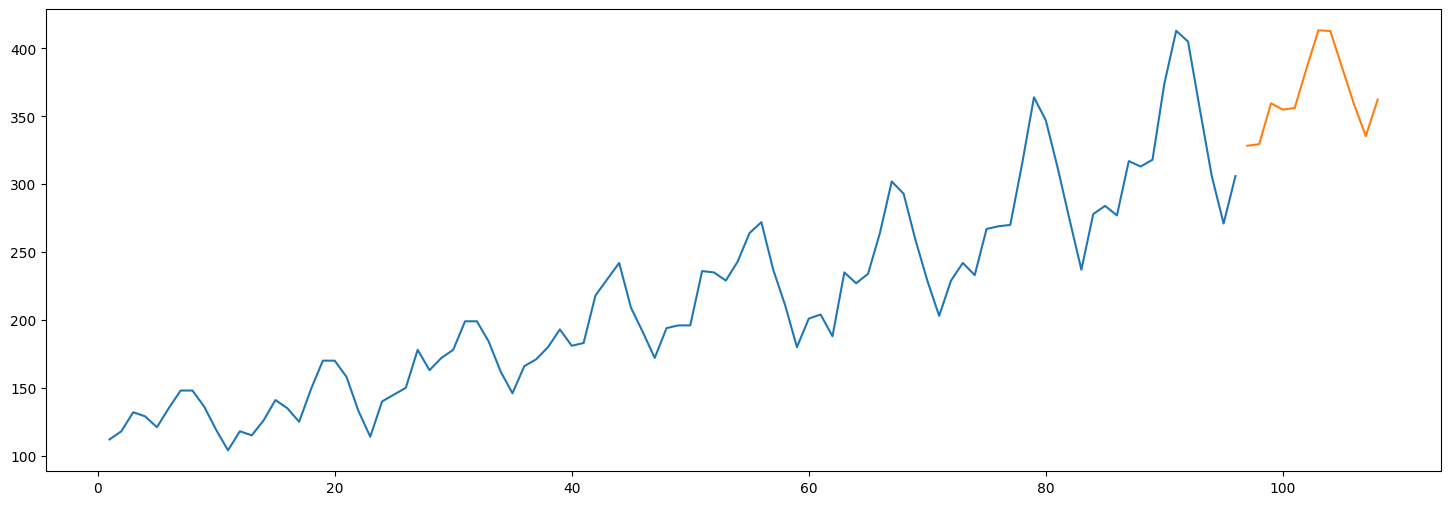

In [35]:
plt.figure(figsize=(18,6))
plt.plot(air1.t , air1.Passengers)
plt.plot(new_df.t , new_df.forcasted) 